In [3]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, losses, optimizers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split

In [3]:
tf.random.set_seed(42)
np.random.seed(42)

In [33]:
IMG_HEIGHT = 256  # Reduced for memory efficiency
IMG_WIDTH = 256   # Can be increased if you have more GPU memory
IMG_CHANNELS = 3
BATCH_SIZE = 8
EPOCHS = 30
LEARNING_RATE = 1e-4
base_filters = 32
DATA_DIR = './' 

In [95]:
CLASS_NAMES = [
    'bridge', 'car bonnet', 'on rails', 'wall', 'fence', 'pole', 'rider',
    'road', 'sidewalk', 'parking', 'sky', 'building', 'rider', 'traffic light',
    'truck', 'bus', 'train', 'motorcycle', 'terrain'
]
NUM_CLASSES = len(CLASS_NAMES)

In [85]:
CLASS_COLORS = np.array([
    [128, 64, 128],    # road
    [244, 35, 232],    # sidewalk
    [70, 70, 70],      # building
    [102, 102, 156],   # wall
    [190, 153, 153],   # fence
    [153, 153, 153],   # pole
    [250, 170, 30],    # traffic light
    [220, 220, 0],     # traffic sign
    [107, 142, 35],    # vegetation
    [152, 251, 152],   # terrain
    [70, 130, 180],    # sky
    [220, 20, 60],     # person
    [255, 0, 0],       # rider
    [0, 0, 142],       # car
    [0, 0, 70],        # truck
    [0, 60, 100],      # bus
    [0, 80, 100],      # train
    [0, 0, 230],       # motorcycle
    [119, 11, 32]      # bicycle
], dtype=np.uint8)

In [39]:
def load_image_paths(data_dir):
    image_paths = []
    mask_paths = []
    
    for split in ['train', 'val']:
        left_img_dir = os.path.join(data_dir, 'leftImg8bit', split)
        gt_fine_dir = os.path.join(data_dir, 'gtFine', split)
        
        for city in os.listdir(left_img_dir):
            city_left_img_dir = os.path.join(left_img_dir, city)
            city_gt_fine_dir = os.path.join(gt_fine_dir, city)
            
            for img_name in os.listdir(city_left_img_dir):
                if not img_name.endswith('.png'):
                    continue
                    
                # Get corresponding mask (we'll use labelIds for simplicity)
                base_name = img_name.replace('_leftImg8bit.png', '')
                mask_name = f"{base_name}_gtFine_labelIds.png"
                mask_path = os.path.join(city_gt_fine_dir, mask_name)
                
                if os.path.exists(mask_path):
                    image_paths.append(os.path.join(city_left_img_dir, img_name))
                    mask_paths.append(mask_path)
                    
    return image_paths, mask_paths

In [41]:
def load_and_preprocess_image(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    
    # Load mask (using labelIds)
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    
    # Convert mask to int32 before comparison
    mask = tf.cast(mask, tf.int32)
    
    # Clip labels to valid range
    mask = tf.where(mask >= NUM_CLASSES, NUM_CLASSES - 1, mask)
    mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH], method='nearest')
    mask = tf.squeeze(mask)  # Remove channel dimension
    
    # One-hot encode the mask
    mask = tf.one_hot(mask, NUM_CLASSES)  # mask is already int32
    
    return image, mask

In [43]:
def create_dataset(image_paths, mask_paths, batch_size=BATCH_SIZE, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(image_paths))
    
    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset

In [45]:
def conv_block(x, filters, use_separable=True, use_bottleneck=False):
    conv = layers.SeparableConv2D if use_separable else layers.Conv2D
    
    if use_bottleneck:
        x = layers.Conv2D(filters//4, 1, padding='same')(x)  # Bottleneck
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
    
    x = conv(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = conv(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    return x

In [47]:
def build_unet(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    inputs = layers.Input(input_shape)

    x1 = conv_block(inputs, 32, use_bottleneck=False)
    p1 = layers.MaxPool2D(2)(x1)
    x2 = conv_block(p1, 64, use_bottleneck=True)
    p2 = layers.MaxPool2D(2)(x2)
    b = conv_block(p2, 128, use_bottleneck=True)
    
    u1 = layers.UpSampling2D(2)(b)
    u1 = layers.Concatenate()([u1, x2])
    u1 = conv_block(u1, 64, use_bottleneck=True)
    
    u2 = layers.UpSampling2D(2)(u1)
    u2 = layers.Concatenate()([u2, x1])
    u2 = conv_block(u2, 32, use_bottleneck=False)
    
    outputs = layers.Conv2D(NUM_CLASSES, 1, activation='softmax')(u2)
    
    model = models.Model(inputs, outputs, name='Fast_UNet')
    
    tf.config.optimizer.set_jit(True)  
    policy = tf.keras.mixed_precision.Policy('mixed_float16')
    tf.keras.mixed_precision.set_global_policy(policy)
    
    return model

In [49]:
def display_sample(display_list, titles=None):
    plt.figure(figsize=(18, 18))
    
    if titles is None:
        titles = ['Input Image', 'True Mask', 'Predicted Mask']
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        if display_list[i].shape[-1] == 3:
            # RGB image
            plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        elif len(display_list[i].shape) == 2 or display_list[i].shape[-1] == 1:
            # Grayscale mask
            mask = display_list[i]
            if len(mask.shape) == 3:
                mask = np.squeeze(mask)
            plt.imshow(mask, cmap='gray')
        else:
            # One-hot encoded mask
            mask = np.argmax(display_list[i], axis=-1)
            mask = CLASS_COLORS[mask]
            plt.imshow(mask)
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

In [51]:
def visualize_dataset(dataset, num_samples=3):
    """Visualize samples from the dataset"""
    for images, masks in dataset.take(1):
        for i in range(min(num_samples, BATCH_SIZE)):
            display_sample([images[i], masks[i]], ['Input Image', 'True Mask'])

In [53]:
print("Loading dataset...")
image_paths, mask_paths = load_image_paths(DATA_DIR)

Loading dataset...


In [55]:
if not any('val' in path for path in image_paths):
        train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(
            image_paths, mask_paths, test_size=0.2, random_state=42)
else:
        # Separate train and val paths
        train_image_paths = [p for p in image_paths if 'train' in p]
        val_image_paths = [p for p in image_paths if 'val' in p]
        train_mask_paths = [p for p in mask_paths if 'train' in p]
        val_mask_paths = [p for p in mask_paths if 'val' in p]
print(f"Number of training samples: {len(train_image_paths)}")
print(f"Number of validation samples: {len(val_image_paths)}")
    
    # Create datasets
train_dataset = create_dataset(train_image_paths, train_mask_paths)
val_dataset = create_dataset(val_image_paths, val_mask_paths, shuffle=False)

Number of training samples: 2975
Number of validation samples: 500


Visualizing training samples...


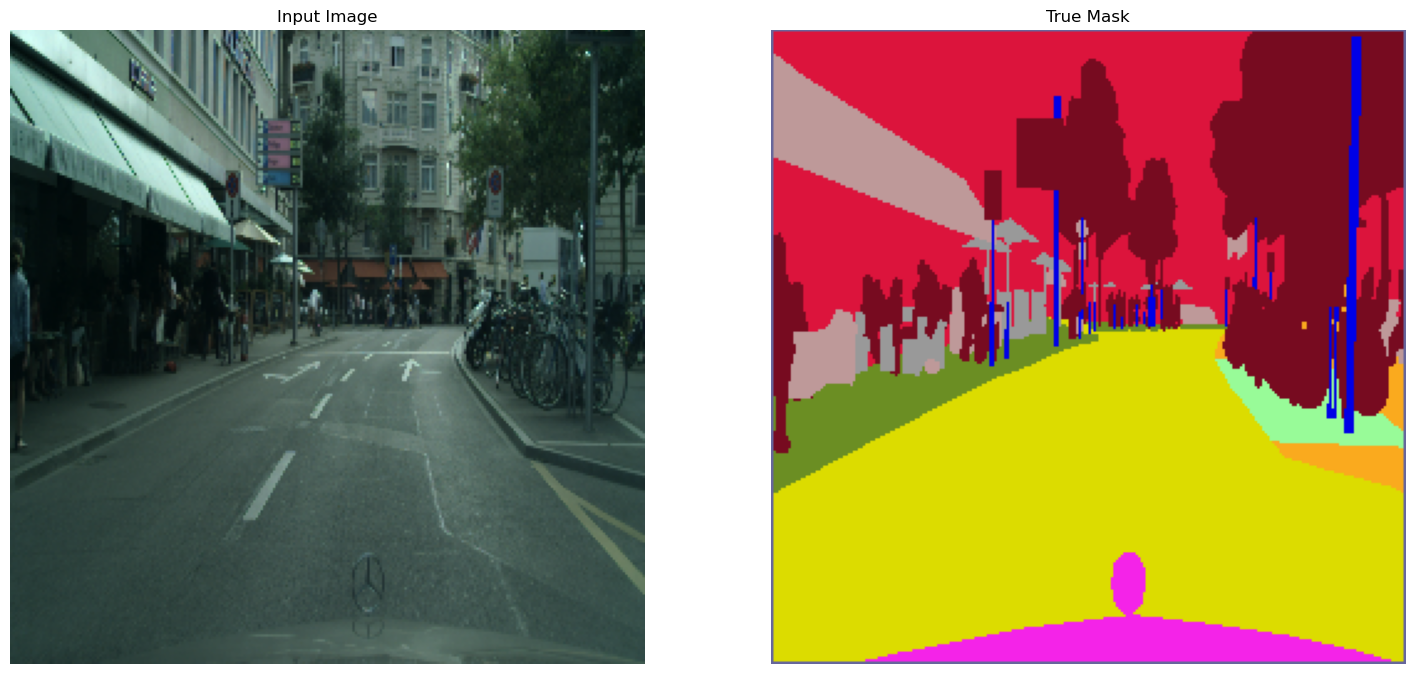

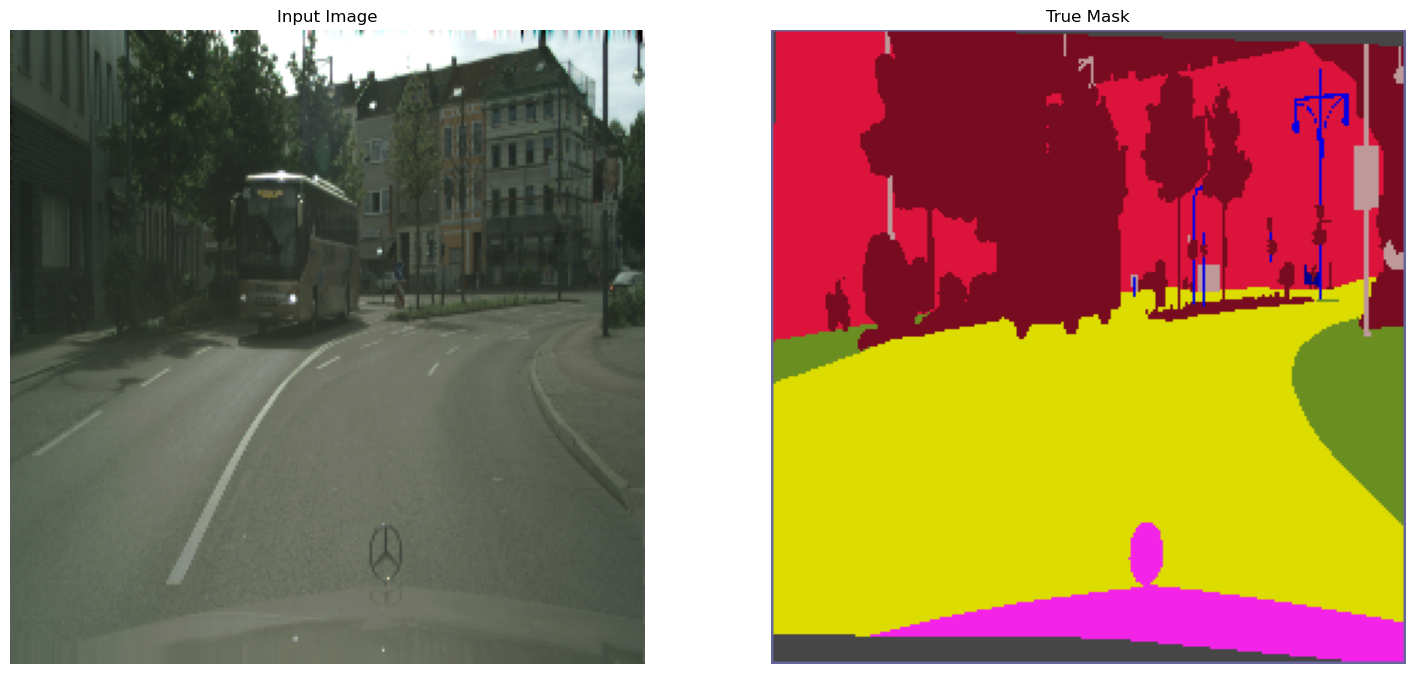

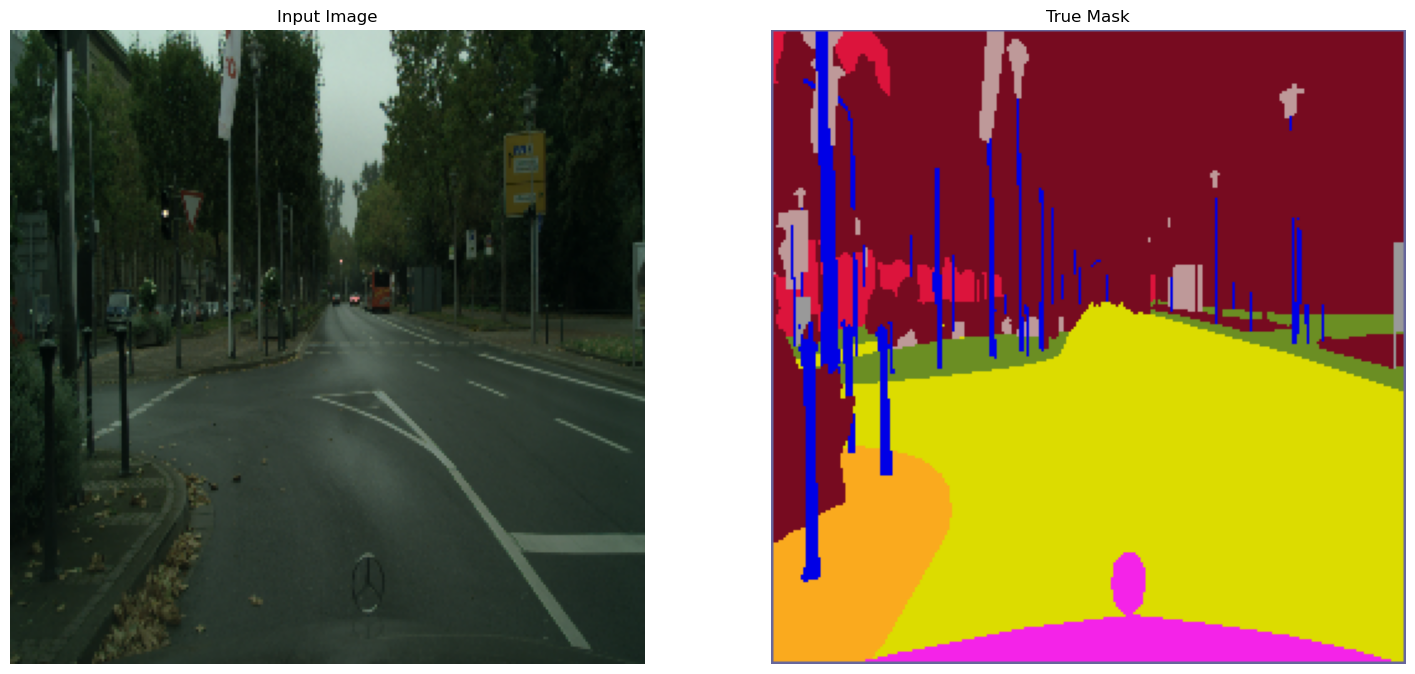

In [345]:
print("Visualizing training samples...")
visualize_dataset(train_dataset)

In [346]:
model = build_unet()

In [349]:
model.compile(optimizer=optimizers.Adam(LEARNING_RATE),
                  loss=losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])
model.summary()

Model: "Fast_UNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)   │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv2d_38           │ (None, 256, 256, 32)      │             155 │ input_layer_12[0][0]       │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_59        │ (None, 256, 256, 32)      │             128 │ separable_conv2d_38[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_13 (ReLU)               │ (None, 256, 256, 32)      │               0 │ batch_normalization_59[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv2d_39           │ (None, 256, 256, 32)      │           1,344 │ re_lu_13[0][0]             │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_60        │ (None, 256, 256, 32)      │             128 │ separable_conv2d_39[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_14 (ReLU)               │ (None, 256, 256, 32)      │               0 │ batch_normalization_60[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_14              │ (None, 128, 128, 32)      │               0 │ re_lu_14[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_23 (Conv2D)            │ (None, 128, 128, 16)      │             528 │ max_pooling2d_14[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_61        │ (None, 128, 128, 16)      │              64 │ conv2d_23[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_15 (ReLU)               │ (None, 128, 128, 16)      │               0 │ batch_normalization_61[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv2d_40           │ (None, 128, 128, 64)      │           1,232 │ re_lu_15[0][0]             │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_62        │ (None, 128, 128, 64)      │             256 │ separable_conv2d_40[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 50,062 (195.55 KB)

 Trainable params: 48,654 (190.05 KB)

 Non-trainable params: 1,408 (5.50 KB)

In [351]:
callbacks = [
        tf.keras.callbacks.ModelCheckpoint('unet_cityscapes.h5', save_best_only=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    ]

In [361]:
'''history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=100,
        initial_epoch= 30,
        callbacks=callbacks
    )'''

Epoch 31/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 865s 2s/step - accuracy: 0.8164 - loss: 0.6041 - val_accuracy: 0.8019 - val_loss: 0.6496 - learning_rate: 1.0000e-04
Epoch 32/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 832s 2s/step - accuracy: 0.8201 - loss: 0.5932 - val_accuracy: 0.7873 - val_loss: 0.6939 - learning_rate: 1.0000e-04
Epoch 33/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 833s 2s/step - accuracy: 0.8151 - loss: 0.6081 - val_accuracy: 0.7301 - val_loss: 0.8739 - learning_rate: 1.0000e-04
Epoch 34/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 869s 2s/step - accuracy: 0.8158 - loss: 0.6089 - val_accuracy: 0.7985 - val_loss: 0.6577 - learning_rate: 1.0000e-04
Epoch 35/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 852s 2s/step - accuracy: 0.8169 - loss: 0.6003 - val_accuracy: 0.7892 - val_loss: 0.6906 - learning_rate: 1.0000e-04
Epoch 36/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 876s 2s/step - accuracy: 0.8205 - loss: 0.5913 - val_accuracy: 0.8044 - val_loss: 0.6417 - learning_rate: 1.0000e-04
Epoch 37/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 858s

372/372 ━━━━━━━━━━━━━━━━━━━━ 768s 2s/step - accuracy: 0.8220 - loss: 0.5881 - val_accuracy: 0.8102 - val_loss: 0.6232 - learning_rate: 1.0000e-04
Epoch 39/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 710s 2s/step - accuracy: 0.8233 - loss: 0.5815 - val_accuracy: 0.6116 - val_loss: 1.3855 - learning_rate: 1.0000e-04
Epoch 40/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 705s 2s/step - accuracy: 0.8242 - loss: 0.5776 - val_accuracy: 0.8005 - val_loss: 0.6714 - learning_rate: 1.0000e-04
Epoch 41/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 705s 2s/step - accuracy: 0.8208 - loss: 0.5899 - val_accuracy: 0.7697 - val_loss: 0.7518 - learning_rate: 1.0000e-04
Epoch 42/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 699s 2s/step - accuracy: 0.8268 - loss: 0.5705 - val_accuracy: 0.8091 - val_loss: 0.6382 - learning_rate: 1.0000e-04
Epoch 43/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 707s 2s/step - accuracy: 0.8244 - loss: 0.5751 - val_accuracy: 0.7483 - val_loss: 0.8036 - learning_rate: 1.0000e-04
Epoch 44/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accu

372/372 ━━━━━━━━━━━━━━━━━━━━ 794s 2s/step - accuracy: 0.8256 - loss: 0.5732 - val_accuracy: 0.8192 - val_loss: 0.5988 - learning_rate: 1.0000e-05
Epoch 45/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8294 - loss: 0.5599

372/372 ━━━━━━━━━━━━━━━━━━━━ 838s 2s/step - accuracy: 0.8294 - loss: 0.5599 - val_accuracy: 0.8195 - val_loss: 0.5972 - learning_rate: 1.0000e-05
Epoch 46/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 851s 2s/step - accuracy: 0.8269 - loss: 0.5713 - val_accuracy: 0.8194 - val_loss: 0.5980 - learning_rate: 1.0000e-05
Epoch 47/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 850s 2s/step - accuracy: 0.8273 - loss: 0.5676 - val_accuracy: 0.8188 - val_loss: 0.5999 - learning_rate: 1.0000e-05
Epoch 48/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 850s 2s/step - accuracy: 0.8280 - loss: 0.5675 - val_accuracy: 0.8192 - val_loss: 0.6002 - learning_rate: 1.0000e-05
Epoch 49/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 856s 2s/step - accuracy: 0.8269 - loss: 0.5684 - val_accuracy: 0.8193 - val_loss: 0.5986 - learning_rate: 1.0000e-05
Epoch 50/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 886s 2s/step - accuracy: 0.8285 - loss: 0.5643 - val_accuracy: 0.8195 - val_loss: 0.5974 - learning_rate: 1.0000e-05
Epoch 51/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accu

372/372 ━━━━━━━━━━━━━━━━━━━━ 850s 2s/step - accuracy: 0.8281 - loss: 0.5652 - val_accuracy: 0.8202 - val_loss: 0.5961 - learning_rate: 1.0000e-06
Epoch 52/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8293 - loss: 0.5575

372/372 ━━━━━━━━━━━━━━━━━━━━ 848s 2s/step - accuracy: 0.8292 - loss: 0.5575 - val_accuracy: 0.8204 - val_loss: 0.5949 - learning_rate: 1.0000e-06
Epoch 53/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 870s 2s/step - accuracy: 0.8268 - loss: 0.5701 - val_accuracy: 0.8202 - val_loss: 0.5954 - learning_rate: 1.0000e-06
Epoch 54/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8266 - loss: 0.5725

372/372 ━━━━━━━━━━━━━━━━━━━━ 891s 2s/step - accuracy: 0.8266 - loss: 0.5725 - val_accuracy: 0.8204 - val_loss: 0.5948 - learning_rate: 1.0000e-06
Epoch 55/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 783s 2s/step - accuracy: 0.8273 - loss: 0.5690 - val_accuracy: 0.8203 - val_loss: 0.5954 - learning_rate: 1.0000e-06
Epoch 56/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 733s 2s/step - accuracy: 0.8267 - loss: 0.5707 - val_accuracy: 0.8203 - val_loss: 0.5952 - learning_rate: 1.0000e-06
Epoch 57/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 735s 2s/step - accuracy: 0.8263 - loss: 0.5733 - val_accuracy: 0.8204 - val_loss: 0.5951 - learning_rate: 1.0000e-06
Epoch 58/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 719s 2s/step - accuracy: 0.8259 - loss: 0.5720 - val_accuracy: 0.8203 - val_loss: 0.5954 - learning_rate: 1.0000e-07
Epoch 59/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 726s 2s/step - accuracy: 0.8279 - loss: 0.5636 - val_accuracy: 0.8205 - val_loss: 0.5948 - learning_rate: 1.0000e-07
Epoch 60/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 723s 2s/step - ac

372/372 ━━━━━━━━━━━━━━━━━━━━ 719s 2s/step - accuracy: 0.8283 - loss: 0.5630 - val_accuracy: 0.8205 - val_loss: 0.5945 - learning_rate: 1.0000e-07
Epoch 62/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 721s 2s/step - accuracy: 0.8291 - loss: 0.5629 - val_accuracy: 0.8203 - val_loss: 0.5956 - learning_rate: 1.0000e-07
Epoch 63/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 727s 2s/step - accuracy: 0.8277 - loss: 0.5664 - val_accuracy: 0.8204 - val_loss: 0.5949 - learning_rate: 1.0000e-07
Epoch 64/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 722s 2s/step - accuracy: 0.8254 - loss: 0.5742 - val_accuracy: 0.8203 - val_loss: 0.5952 - learning_rate: 1.0000e-07
Epoch 65/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 721s 2s/step - accuracy: 0.8303 - loss: 0.5604 - val_accuracy: 0.8204 - val_loss: 0.5951 - learning_rate: 1.0000e-07
Epoch 66/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 716s 2s/step - accuracy: 0.8310 - loss: 0.5560 - val_accuracy: 0.8204 - val_loss: 0.5953 - learning_rate: 1.0000e-07
Epoch 67/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 724s 2s/step - ac

In [5]:

model = load_model("unet_cityscapes.h5")

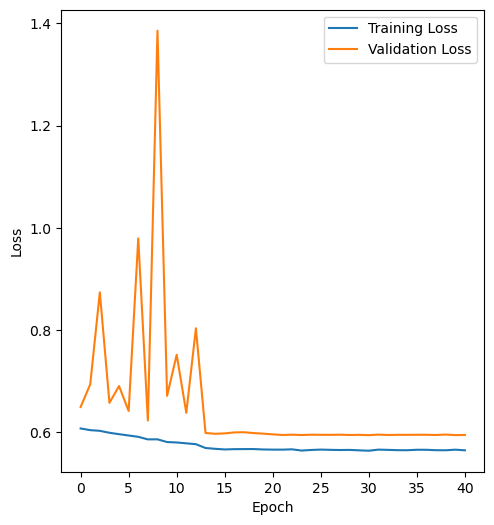

In [363]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

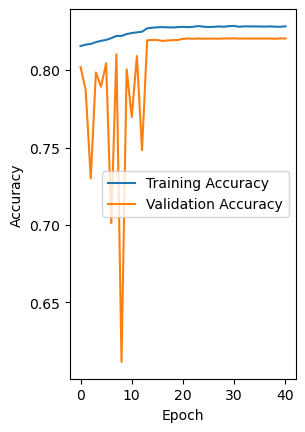

In [365]:
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step


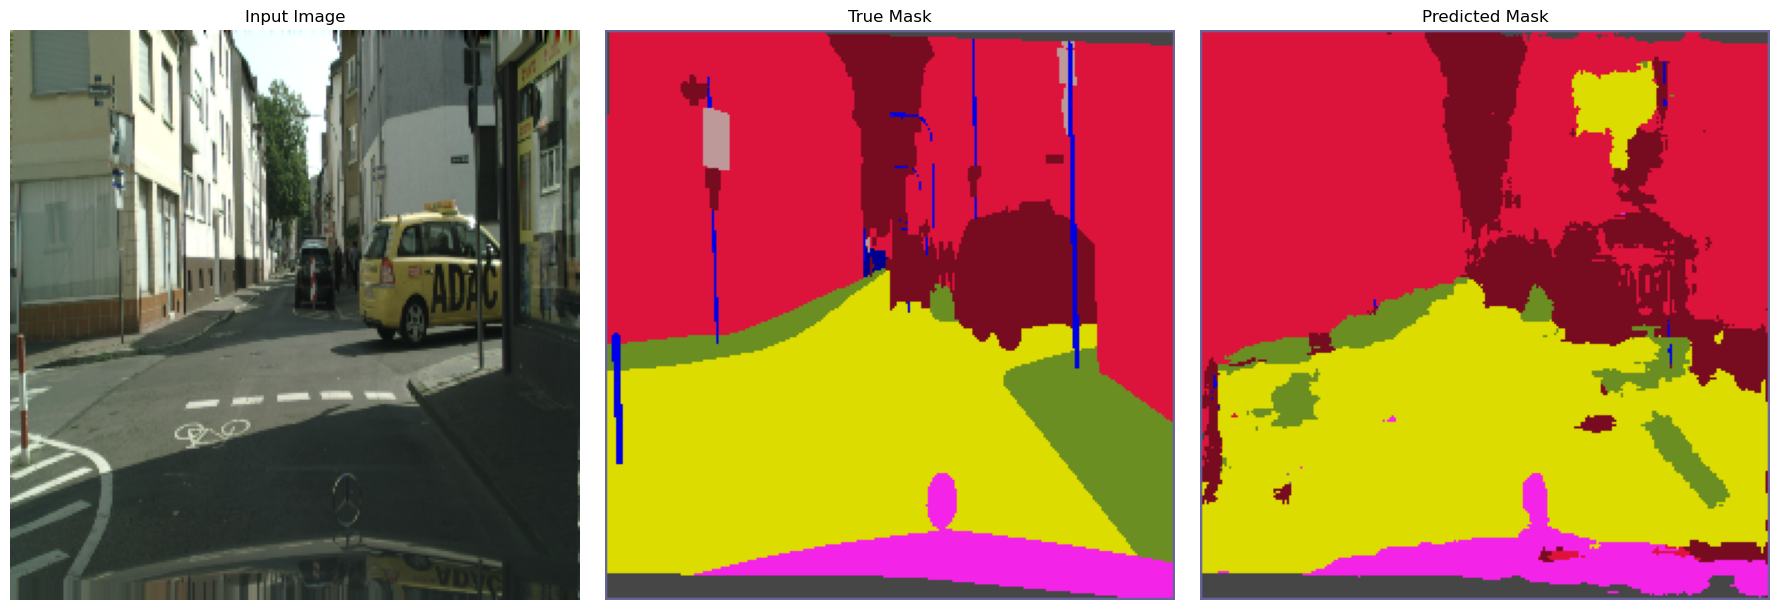

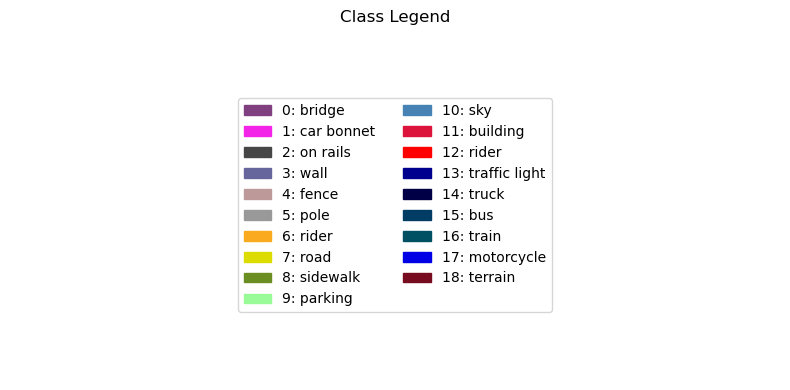

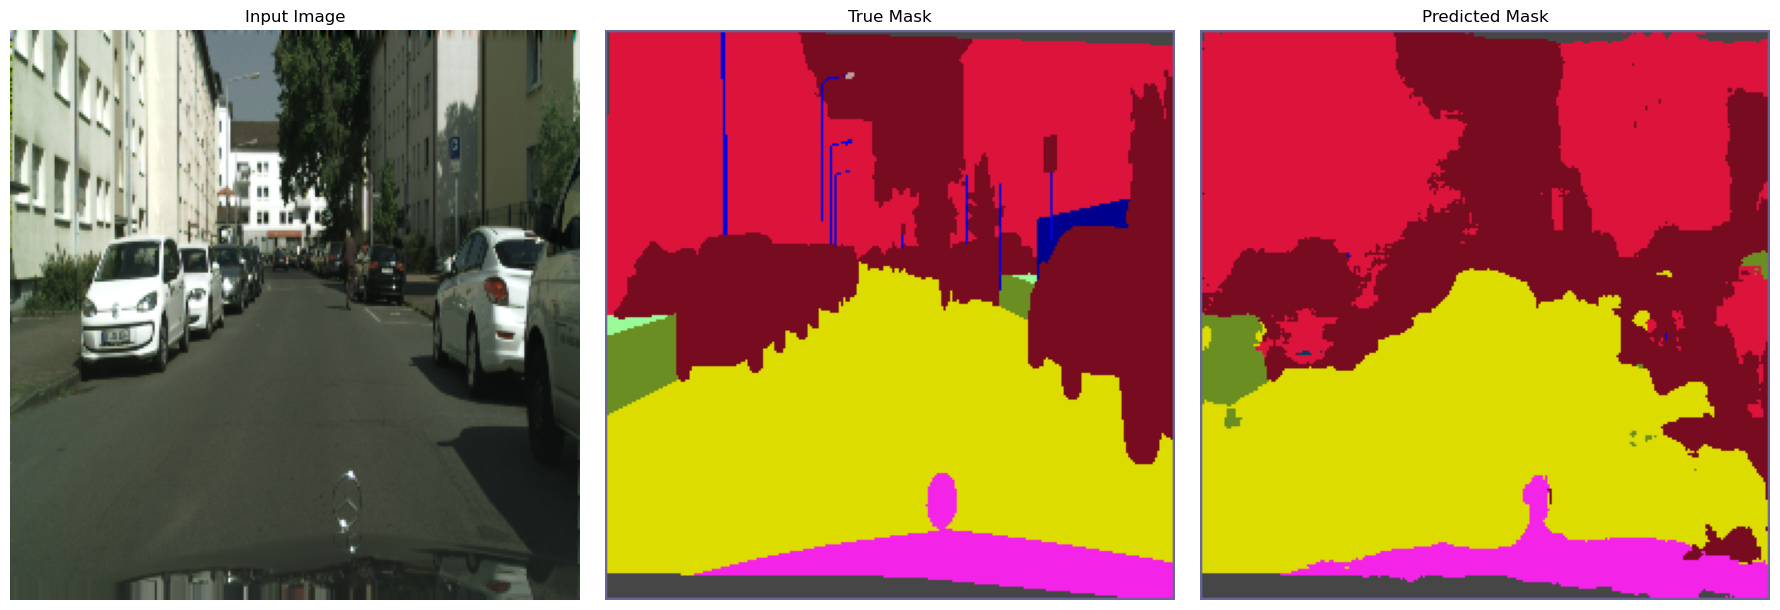

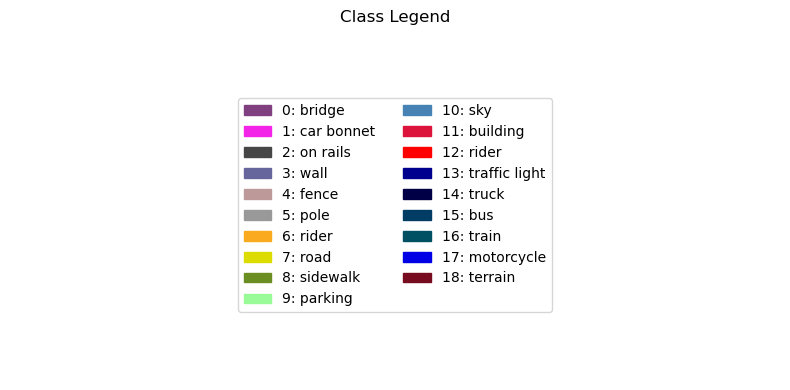

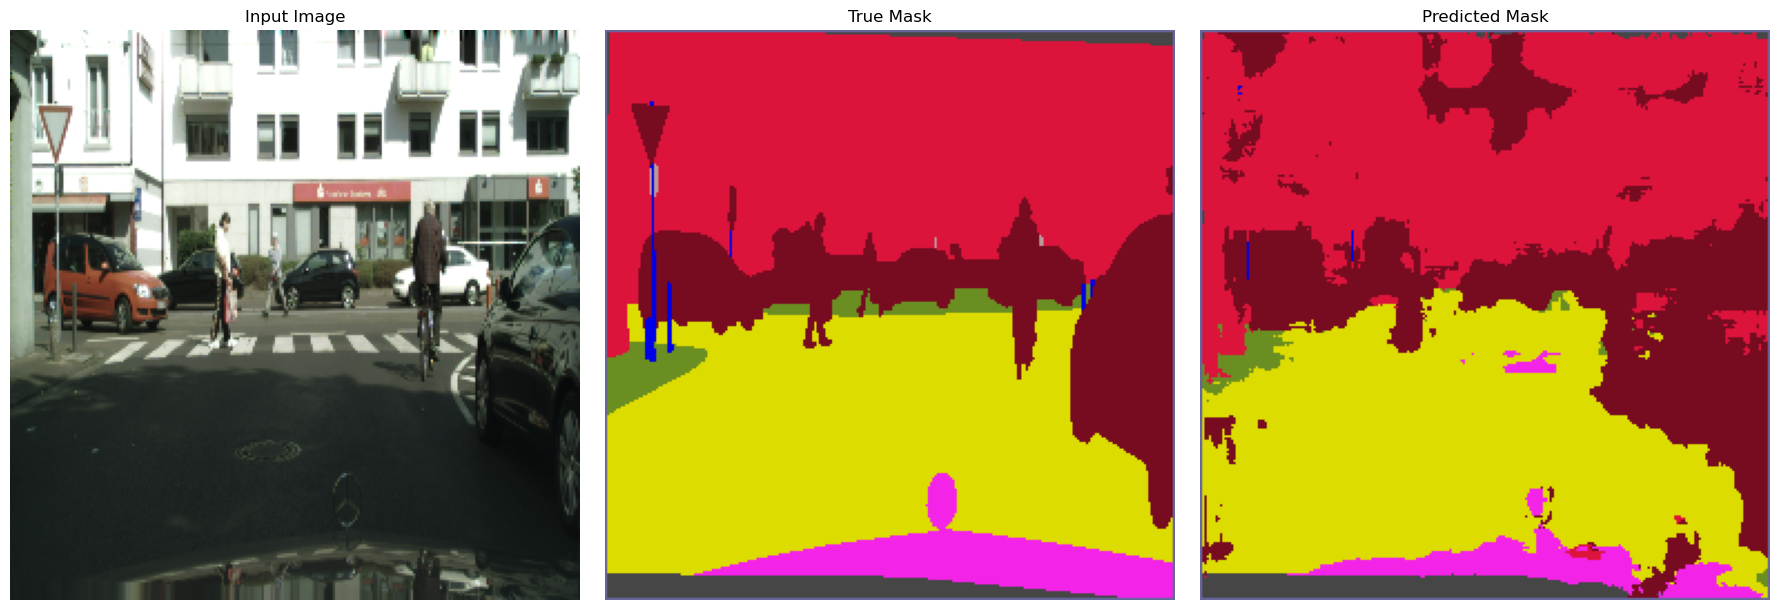

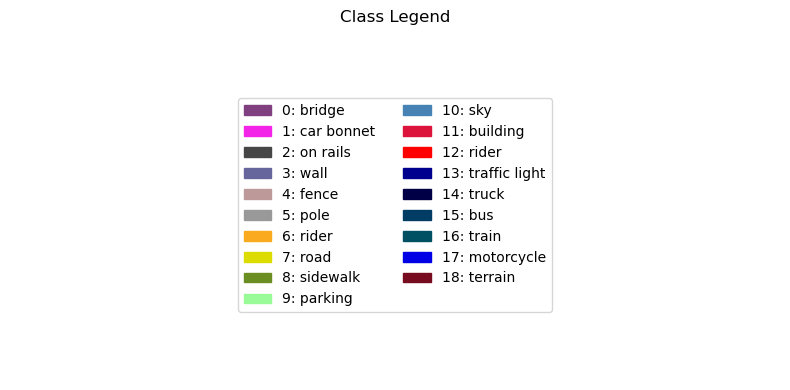

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step


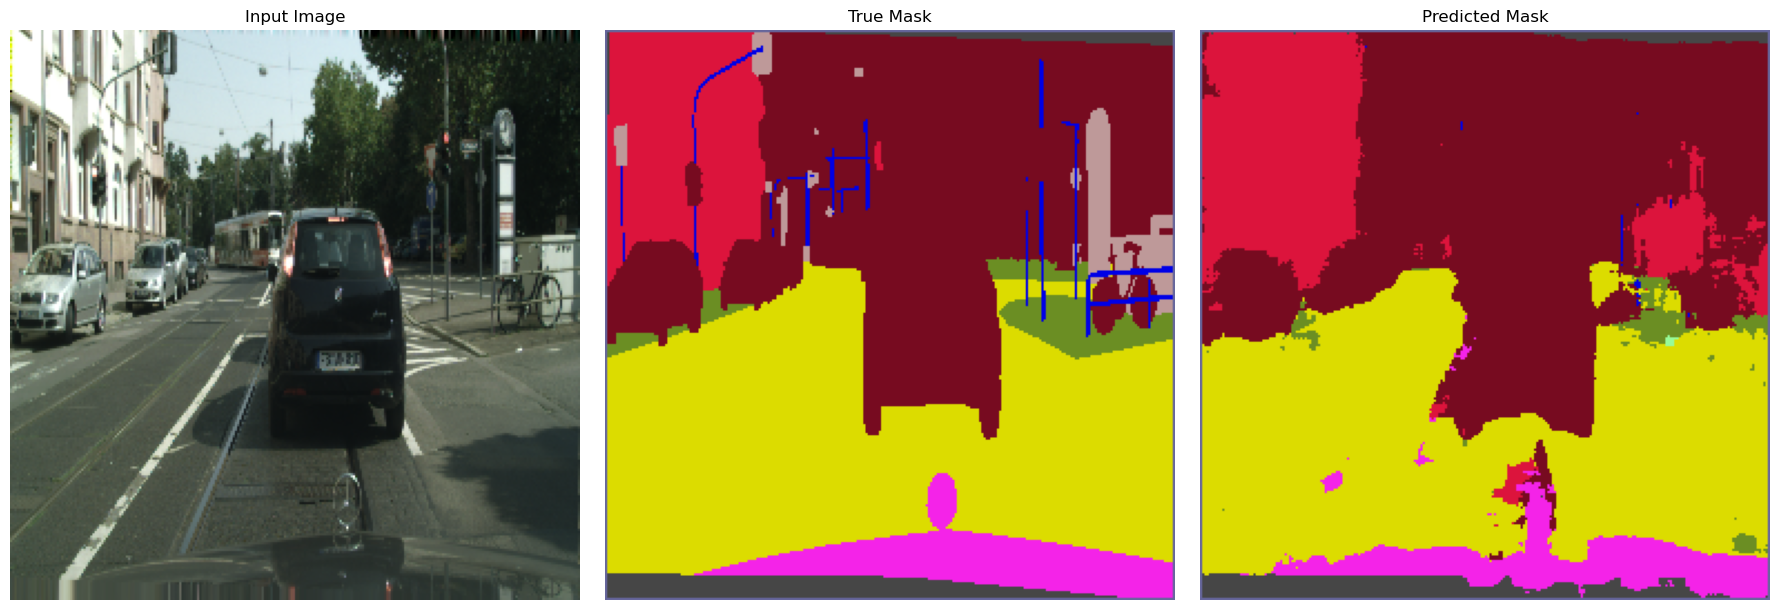

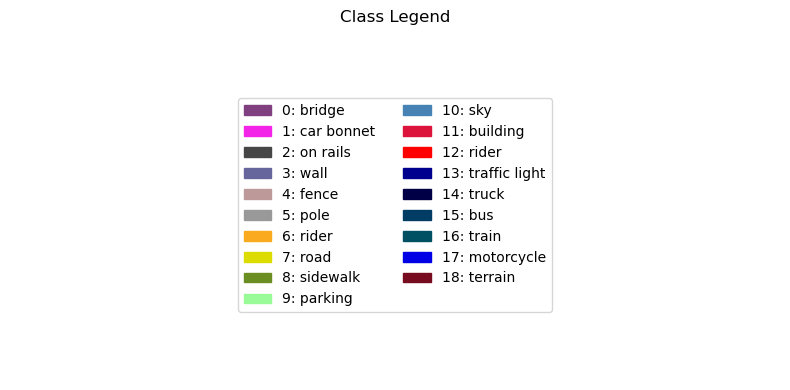

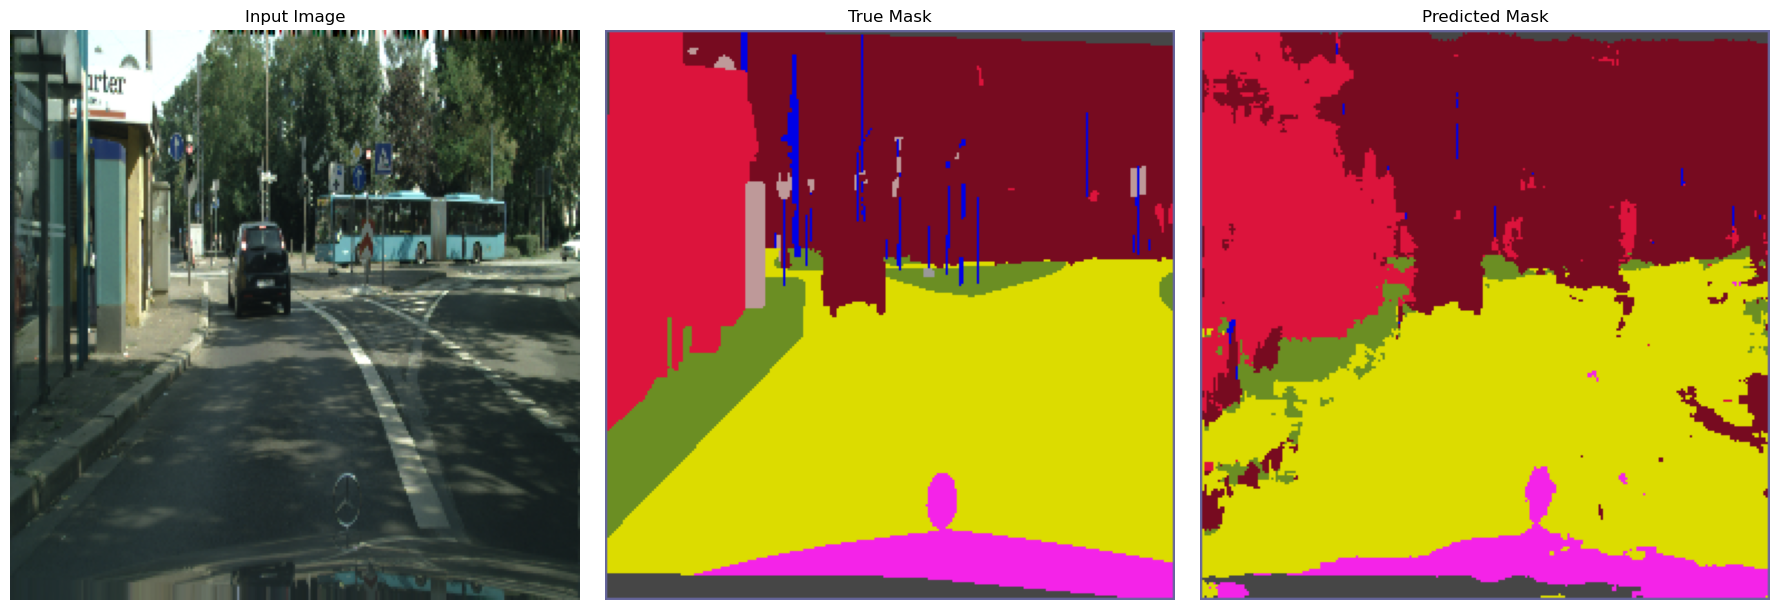

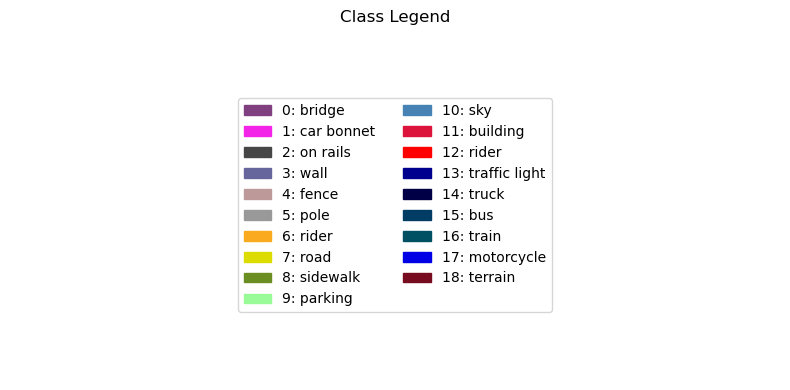

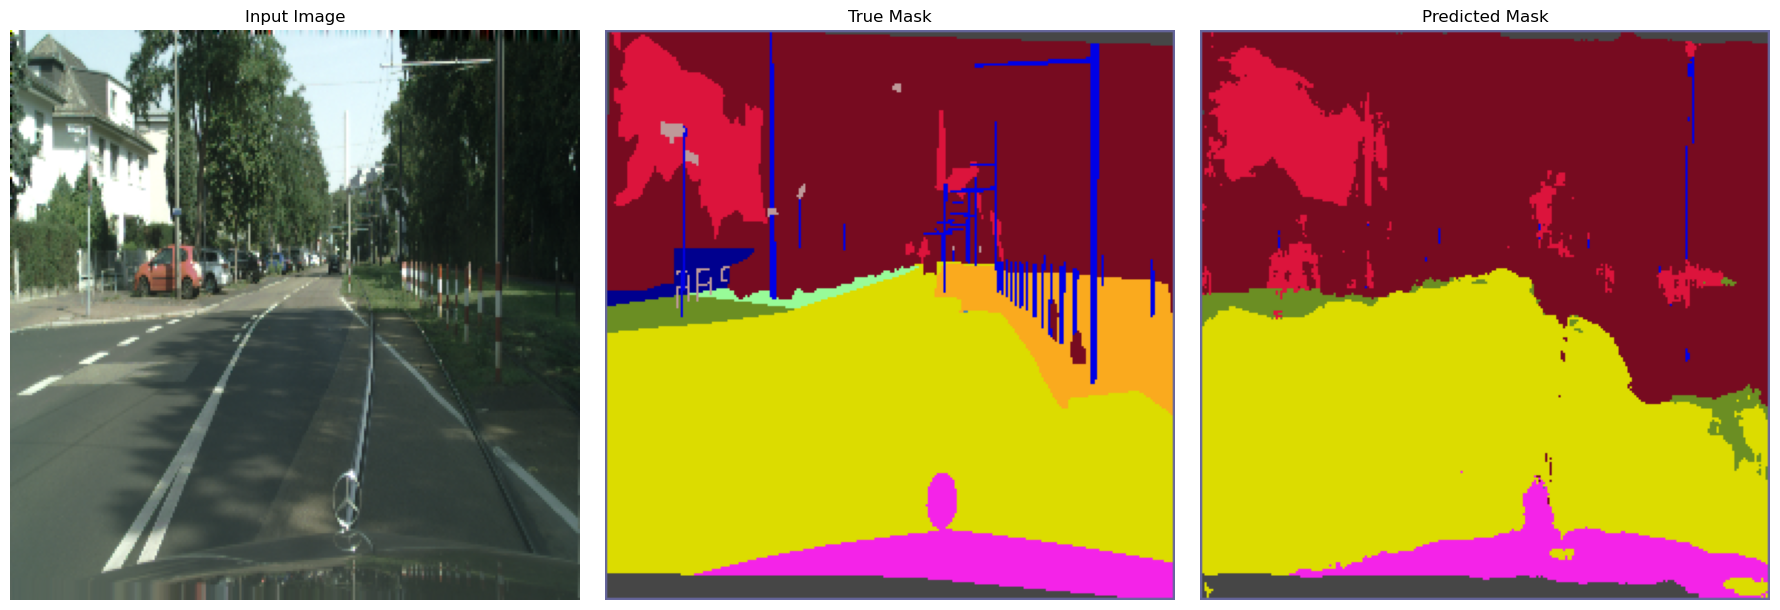

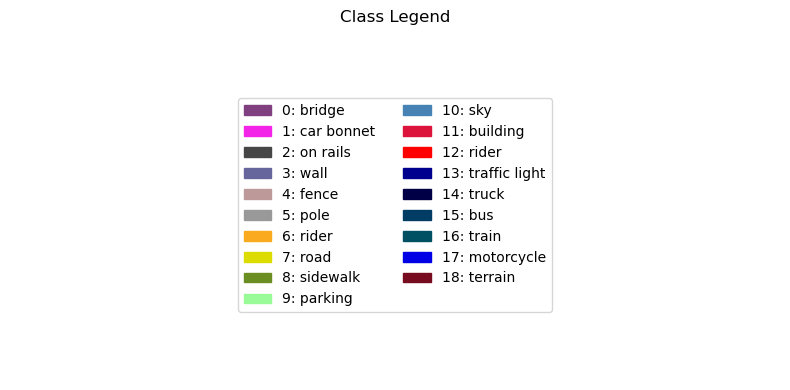

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


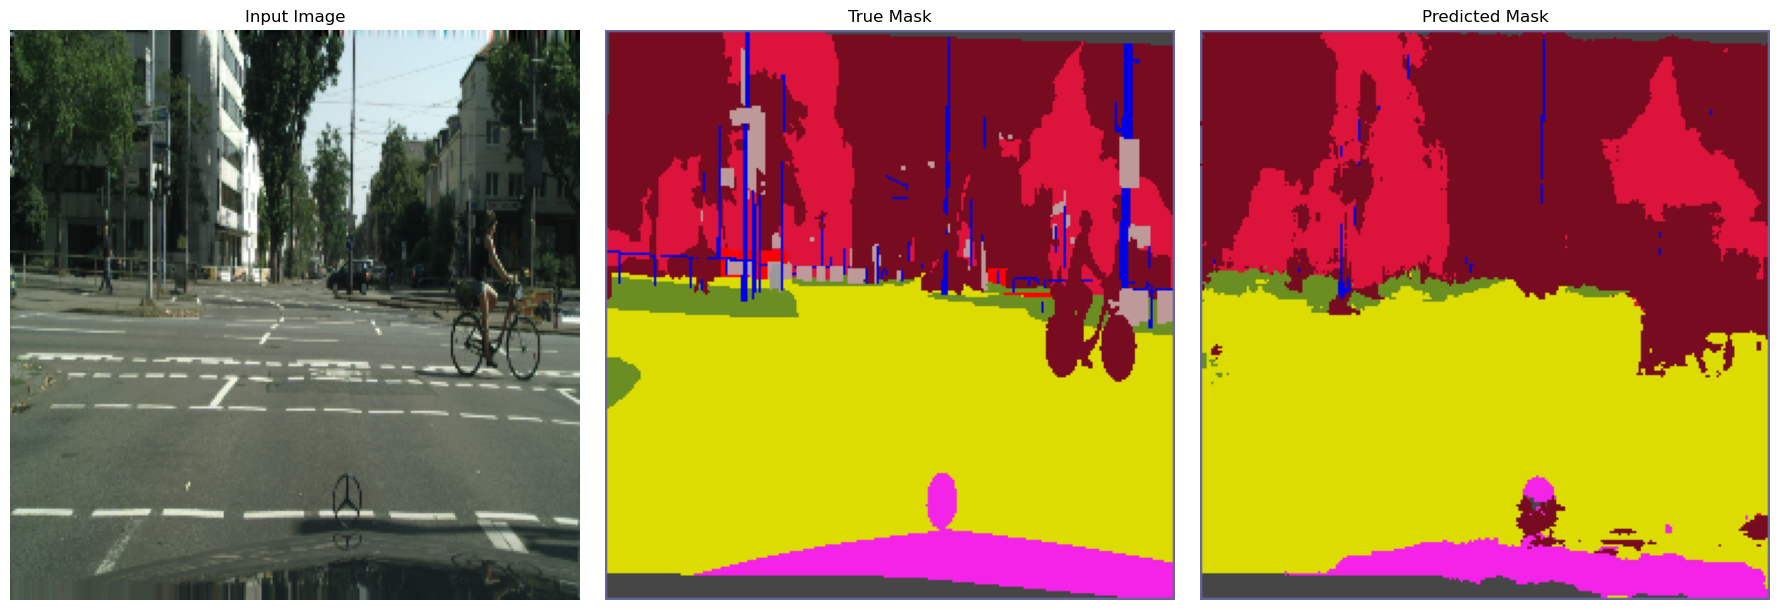

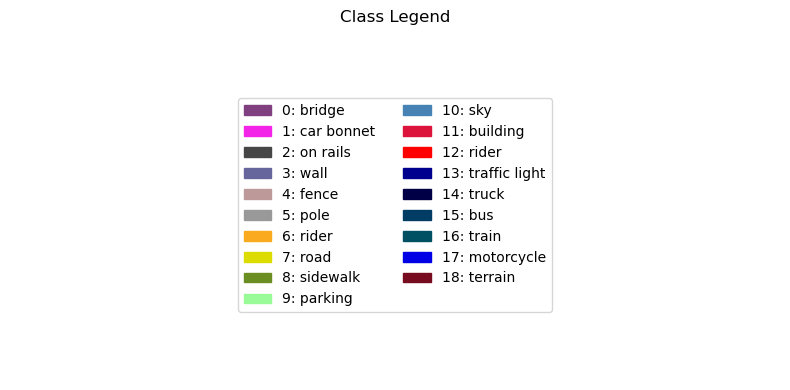

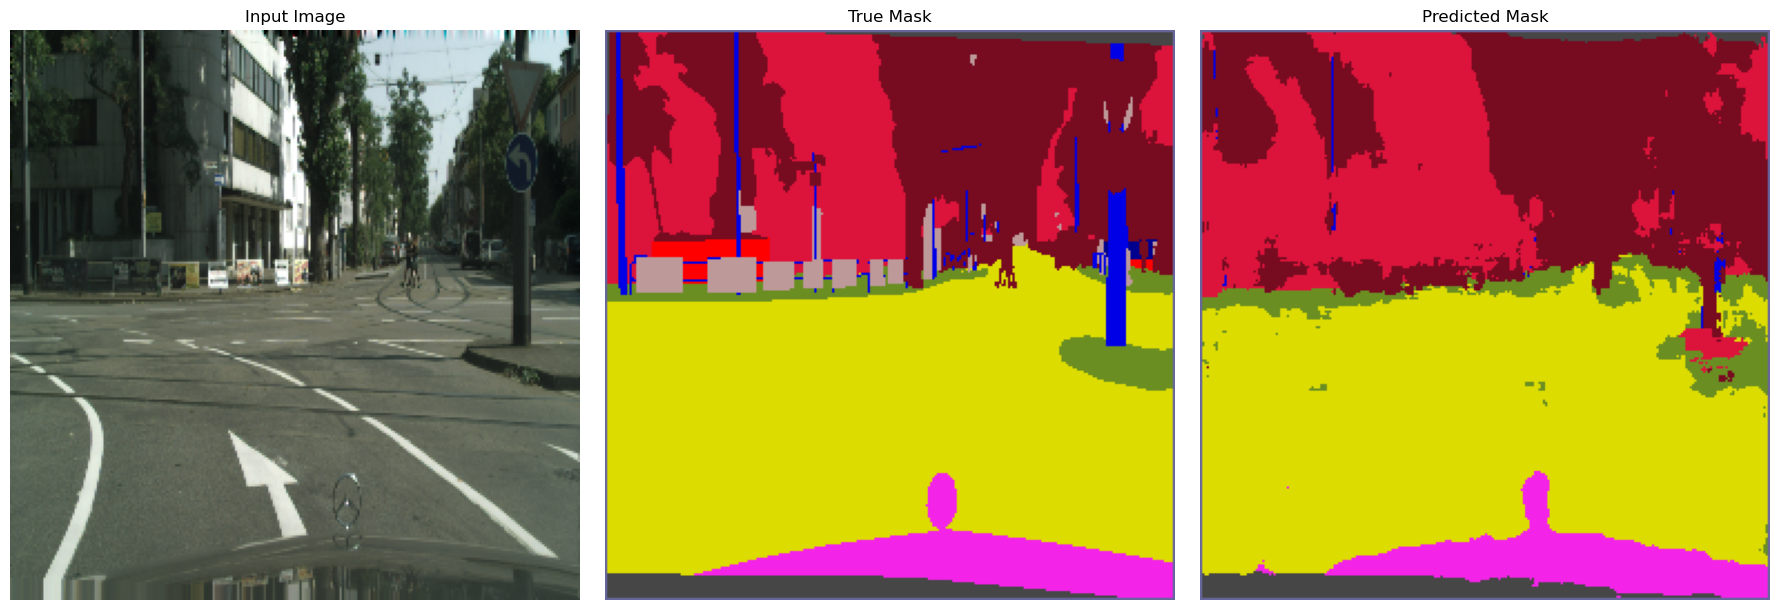

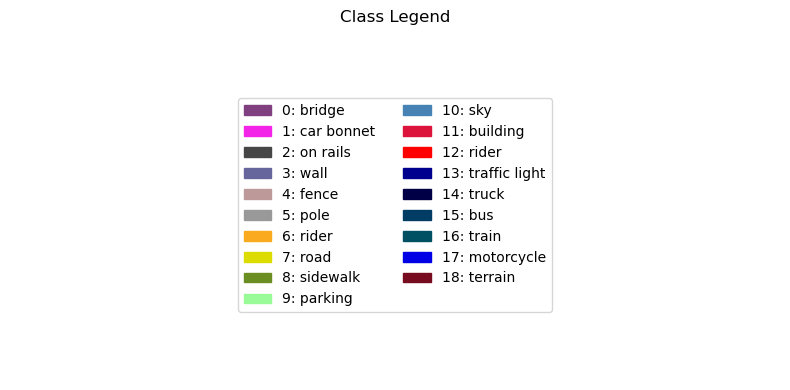

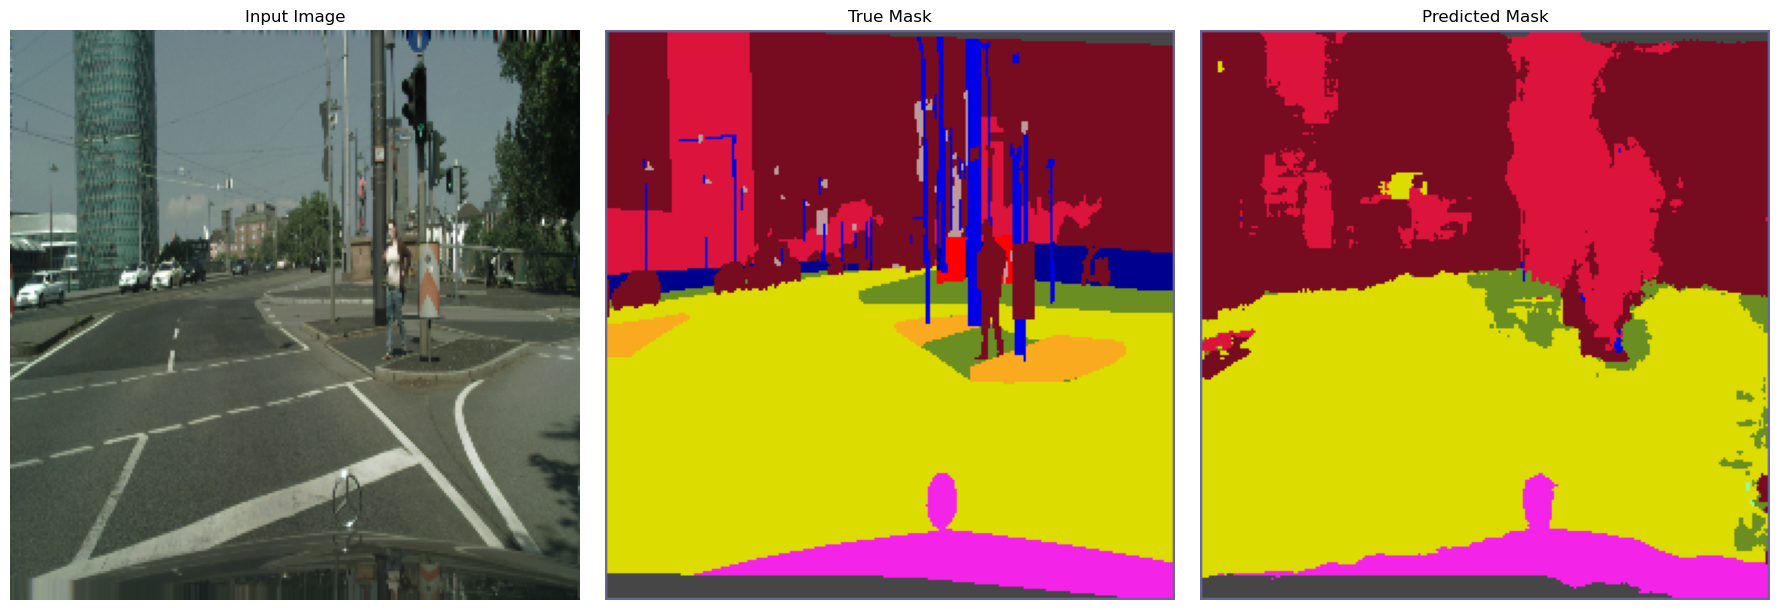

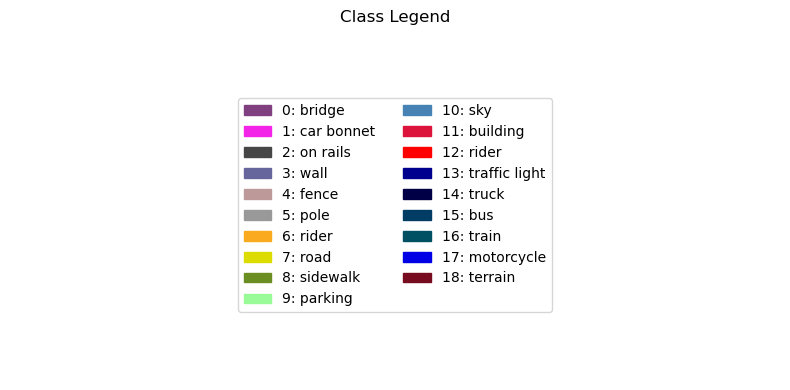

In [97]:
def display_sample(display_list, titles):
    plt.figure(figsize=(18, 6))
    
    # Display images
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(titles[i])
        
        if i == 0: 
            plt.imshow(display_list[i])
        else:  
            if display_list[i].ndim == 3 and display_list[i].shape[-1] > 1:
                mask = np.argmax(display_list[i], axis=-1)
                rgb_mask = CLASS_COLORS[mask]
                plt.imshow(rgb_mask)
            else:
                plt.imshow(display_list[i], cmap='gray')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(8, 4))
    legend_elements = [plt.Rectangle((0, 0), 1, 1, color=color/255, 
                      label=f"{idx}: {name}") for idx, (color, name) in enumerate(zip(CLASS_COLORS, CLASS_NAMES))]
    
    plt.legend(handles=legend_elements, loc='center', ncol=2)
    plt.axis('off')
    plt.title('Class Legend')
    plt.tight_layout()
    plt.show()

# Usage remains the same
for images, masks in val_dataset.take(3):
    pred_masks = model.predict(images)
    for i in range(min(3, BATCH_SIZE)):
        display_sample([images[i], masks[i], pred_masks[i]], 
                      ['Input Image', 'True Mask', 'Predicted Mask'])